In [1]:
import requests
import time
from tempfile import TemporaryDirectory
from IPython.display import clear_output, FileLink, Image, display
from zipfile import ZipFile
from pyarrow import parquet
import json
import os

COSMOS_BASE_URL = "http://cosmos0003.chtc.wisc.edu:8089/cosmos_service"
SAMPLE_PDF_URL = "https://www.nature.com/articles/s41591-020-0883-7.pdf"
SAMPLE_PDF_PATH = "sidarthe.pdf"


### Submit a PDF for Processing

Make a POST request to the base URL containing a multipart form with the contents of the file in the `pdf` field.
Other form fields include:
- `compress_images` (default `True`): Return compressed JPG images if `True`, uncompressed PNGs otherwise.  

In [ ]:
# Download a local copy of the PDF

with open(SAMPLE_PDF_PATH, 'wb') as pdf_writer:
    pdf_writer.write(requests.get(SAMPLE_PDF_URL).content)


In [12]:
# Submit the locally copied PDF to the COSMOS processing pipeline

submit_endpoint = COSMOS_BASE_URL + '/process/'

with open(SAMPLE_PDF_PATH, 'rb') as pdf_to_parse:
    file_form = {'pdf': pdf_to_parse }
    data_form = {'compress_images': False }

    response = requests.post(submit_endpoint, files=file_form, data=data_form)

    response_data = response.json()
    job_id = response_data['job_id']

    status_endpoint = response_data['status_endpoint']
    results_endpoint = response_data['result_endpoint']

    print(f"Message: {response_data['message']}\n"
          f"Job ID: {response_data['job_id']}\n"
          f"Status Endpoint: {status_endpoint}\n"
          f"Results Endpoint: {results_endpoint}")


Message: PDF Processing in Background
Job ID: d428ea1a-53d8-45c9-be21-0f538e9463ad
Status Endpoint: http://cosmos0003.chtc.wisc.edu:8088/cosmos_service/process/d428ea1a-53d8-45c9-be21-0f538e9463ad/status
Results Endpoint: http://cosmos0003.chtc.wisc.edu:8088/cosmos_service/process/d428ea1a-53d8-45c9-be21-0f538e9463ad/result


### Monitor COSMOS Processing Status

Poll the URL suffix returned in the `status_endpoint` field of the initial response object.
For the sample document, processing can take up to 5 minutes. The `/status` endpoint
will return several fields, including a `job_completed` field and an `error` field which initially 
`false` and `null` respectively. If the `job_completed` field becomes `true`, then the job completed 
successfully, and if the `error` field becomes non-`null` then the job failed. 

In [6]:
POLL_COUNT = 80
POLL_INTERVAL = 5

job_done = False

for i in range(POLL_COUNT):
    response = requests.get(status_endpoint)
    response_data = response.json()
    clear_output(wait=True)
    print(f"Polled status endpoint {i} times:\n{response_data}")
    job_done = response_data['error'] or response_data['job_completed']
    if job_done:
        break
    time.sleep(POLL_INTERVAL)

if not job_done:
    print(f"ERROR: Job not complete after {POLL_COUNT * POLL_INTERVAL} seconds.")
elif response_data['error']:
    print(f"An unexpected error occurred: {response_data['error']}")
else:
    print(f"Job succeeded after {response_data['time_processing']} seconds.\n"
          f"Results can be viewed at {results_endpoint}")


Polled status endpoint 15 times:
{'job_started': True, 'job_completed': True, 'error': None, 'time_in_queue': 6.995735, 'time_processing': 68.586706}
Job succeeded after 68.586706 seconds.
Results can be viewed at http://cosmos0003.chtc.wisc.edu:8088/cosmos_service/process/fd1e202a-5c76-49d7-9ae0-4729626497dc/result


### Obtain Results

Once the `/status` endpoint indicates that `job_completed` is `true`, the following endpoints will be available via GET request:
- `/result/text`: The text extracted from the document, alongside its bounding boxes and classification, as JSON.
- `/result/extractions/{extraction_type}`: The bounding boxes of individual extraction types, and temporary links to their images, as JSON. 
  Valid extraction types are `equations`, `figures`, and `tables`.
- `/result/images/{image_id}`: Temporary image hosting for the cosmos extractions.
- `/result`: The entire contents of the cosmos processing job as a zip file, containing images of extracted pdf regions and parquet files with those extractions' metadata.

All results are available for 24 hours after image processing completes, after which they will be deleted.

### Extractions (JSON)

In [ ]:
# Extracted document text and bounding boxes
text_data = requests.get(f"{results_endpoint}/text")
print(text_data)
# print(json.dumps(text_data.json(), indent=2))


In [7]:
# Extracted document equations, bounding boxes, and images
equation_data = requests.get(f"{results_endpoint}/extractions/equations")
print(f"{results_endpoint}/extractions/equations")
print(json.dumps(equation_data.json(), indent=2))

http://cosmos0003.chtc.wisc.edu:8088/cosmos_service/process/fd1e202a-5c76-49d7-9ae0-4729626497dc/result/extractions/equations
[
  {
    "pdf_name": "sidarthe.pdf",
    "page_num": 2,
    "bounding_box": [
      623,
      313,
      863,
      391
    ],
    "detect_score": -5.0413770676,
    "content": "8.1",
    "postprocess_score": 0.8280115128,
    "img_pth": "http://cosmos0003.chtc.wisc.edu:8088/cosmos_service/process/fd1e202a-5c76-49d7-9ae0-4729626497dc/result/images/488c56db-7296-45bb-bae3-4f197b537a7b.png"
  },
  {
    "pdf_name": "sidarthe.pdf",
    "page_num": 3,
    "bounding_box": [
      217,
      1189,
      430,
      1227
    ],
    "detect_score": -1.4908663034,
    "content": null,
    "postprocess_score": 0.9991612434,
    "img_pth": "http://cosmos0003.chtc.wisc.edu:8088/cosmos_service/process/fd1e202a-5c76-49d7-9ae0-4729626497dc/result/images/10ede532-9caa-4ed7-8a19-735fb1440951.png"
  },
  {
    "pdf_name": "sidarthe.pdf",
    "page_num": 4,
    "bounding_box": [


In [ ]:
# Extracted document figures, bounding boxes, and images
figure_data = requests.get(f"{results_endpoint}/extractions/figures")
print(json.dumps(figure_data.json(), indent=2))


In [ ]:
# Extracted document tables, bounding boxes, and images
table_data = requests.get(f"{results_endpoint}/extractions/tables")
print(json.dumps(table_data.json(), indent=2))


### Full Results (Zip)

In [10]:
ZIP_DOWNLOAD_PATH = SAMPLE_PDF_PATH.replace('.pdf', '.zip')
with open(ZIP_DOWNLOAD_PATH, 'wb') as writer:
    writer.write(requests.get(results_endpoint).content)

print(f'You can access the downloaded zip file at {FileLink(ZIP_DOWNLOAD_PATH)} .\nIt contains the following files:')

with ZipFile(ZIP_DOWNLOAD_PATH, 'r') as zipfile:
    zipfile.printdir()


You can access the downloaded zip file at /home/westphall/xdd/Cosmos/notebooks/cosmos-service/sidarthe.zip .
It contains the following files:
File Name                                             Modified             Size
sidarthe_sections.parquet                      2024-02-27 10:40:16        13556
9b9bea95-cfef-4759-8871-60a694001370.png       2024-02-27 10:40:16        49013
baf70a8e-c338-4437-9cbf-540d85f14de3.png       2024-02-27 10:40:16         7799
63614b80-2980-4cee-ad3c-b47c7e911c3f.png       2024-02-27 10:40:16        53550
adb995a1-0067-40f9-bbe2-6798563793a5.png       2024-02-27 10:40:16         7208
sidarthe_figures.json                          2024-02-27 10:40:18         2224
488c56db-7296-45bb-bae3-4f197b537a7b.png       2024-02-27 10:40:16         7058
fdfab466-9dcc-491d-b403-adff993aa973.png       2024-02-27 10:40:16        28729
77533d13-3fb1-4ed7-b8f2-7c71c875bfcc.png       2024-02-27 10:40:16       109062
a03890c4-d89f-4f45-9489-c399c965333c.png       2024-02-27 

### View Figures

The zip file contains a number of image files, as well as apache parquet files containing information about those images.
Each parquet file contains information about a separate extraction type (tables, figures, and equations). The names of each
parquet file are based on the name of the input PDF file.

In [8]:
def show_extractions(parquet_path, bb_column, page_column):
    """Utility function to show every extraction from a single COSMOS Parquet file"""
    with (TemporaryDirectory() as td, ZipFile(ZIP_DOWNLOAD_PATH, 'r') as zipfile):
        # extract the parquet file from the zip archive
        zipfile.extract(parquet_path, td)
        # read the parquet file
        parquet_table = parquet.read_table(os.path.join(td, parquet_path))
        pandas_data: pd.DataFrame = parquet_table.to_pandas()
        # TODO the img_path column currently contains the absolute path of the image on the server,
        # rather than the relative path from the root of the zip folder
        pandas_data['img_pth'] = pandas_data['img_pth'].replace('/tmp/tmp.*/','',regex=True)

        # Print each extraction alongside its score, page, and bounding box
        for idx, row in pandas_data.iterrows():
            img_path = row['img_pth']
            zipfile.extract(img_path, td)
            print(f"Extracted Item #{idx+1}\n"
                  f"Page: {row[page_column]}\n"
                  f"Bounding Box: {row[bb_column]}\n"
                  f"Content: {row['content']}\n"
                  f"Score: {row['postprocess_score']}")
            display(Image(os.path.join(td,img_path)))


In [ ]:
# Figures
show_extractions(
    'paper.pdf'.replace('.pdf','_figures.parquet'), 
    'obj_bbs',
    'obj_page')


Extracted Item #1
Page: 2
Bounding Box: [623.22412109 313.69064331 863.22412109 391.69064331]
Content: 8.1
Score: 0.8280115127563477


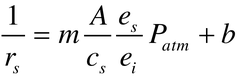

Extracted Item #2
Page: 3
Bounding Box: [ 217.7315979  1189.33117676  430.7315979  1227.33117676]
Content: None
Score: 0.9991612434387207


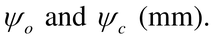

Extracted Item #3
Page: 4
Bounding Box: [212.7951355  413.94015503 745.7951355  461.94015503]
Content: 8.3
Score: 0.9394480586051941


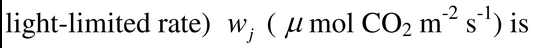

Extracted Item #4
Page: 4
Bounding Box: [1206.44238281  856.71942139 1269.44238281  891.71942139]
Content: 8.4
Score: 0.8177548050880432


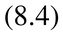

Extracted Item #5
Page: 4
Bounding Box: [212.56552124 413.62109375 745.56552124 461.62109375]
Content: 8.3
Score: 0.6132773160934448


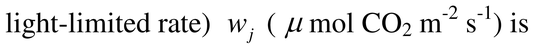

Extracted Item #6
Page: 5
Bounding Box: [631.35528564 414.00341797 846.35528564 492.00341797]
Content: 8.7
Score: 0.9995335340499878


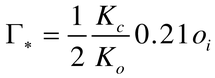

Extracted Item #7
Page: 5
Bounding Box: [ 601.38134766 1307.72473145  881.38134766 1343.72473145]
Content: None
Score: 0.9999892711639404


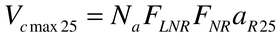

Extracted Item #8
Page: 5
Bounding Box: [1205.83618164  431.77178955 1268.83618164  466.77178955]
Content: 8.7
Score: 0.6783318519592285


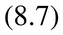

Extracted Item #9
Page: 5
Bounding Box: [1205.51904297 1306.74304199 1268.51904297 1340.74304199]
Content: None
Score: 0.9797419905662537


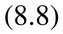

Extracted Item #10
Page: 6
Bounding Box: [597.98431396 949.83898926 883.98431396 993.83898926]
Content: None
Score: 0.9999181032180786


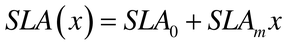

Extracted Item #11
Page: 6
Bounding Box: [ 285.99865723 1176.43847656 1271.99865723 1268.43847656]
Content: 8.11
Score: 0.9106499552726746


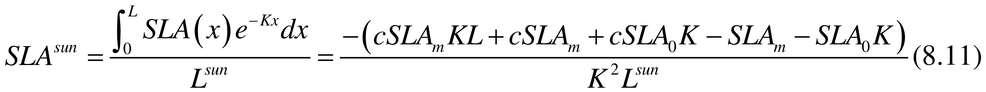

Extracted Item #12
Page: 6
Bounding Box: [ 214.31834412 1304.22045898  583.31834412 1340.22045898]
Content: None
Score: 0.9485935568809509


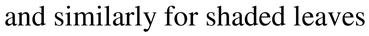

In [11]:
# Equations
show_extractions(
    SAMPLE_PDF_PATH.replace('.pdf','_equations.parquet'), 
    'equation_bb',
    'equation_page')


Extracted Item #1
Page: 3
Bounding Box: [ 203.  241. 1262. 1146.]
Score: 0.9998685121536255


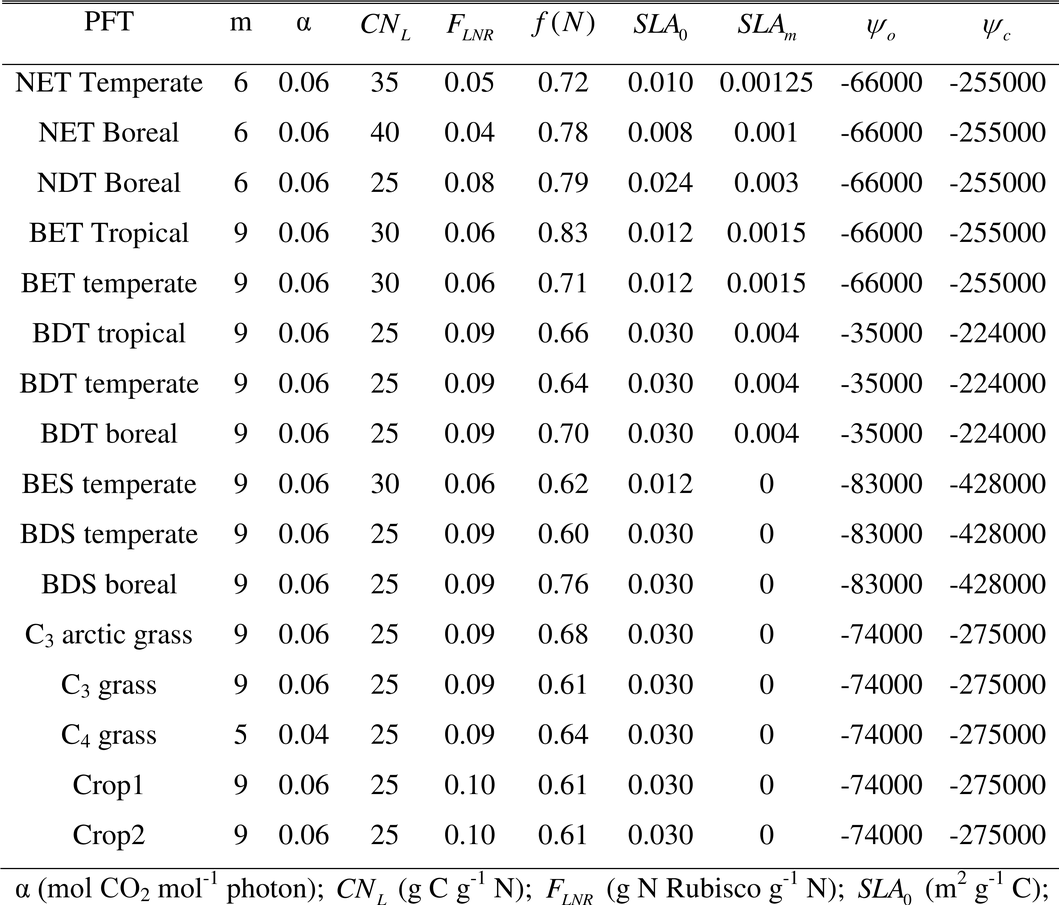

Extracted Item #2
Page: 6
Bounding Box: [ 219.  593. 1265.  695.]
Score: 0.6605368256568909


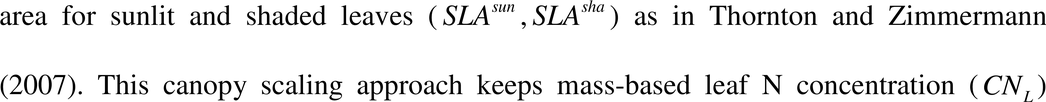

Extracted Item #3
Page: 6
Bounding Box: [ 218. 1112. 1267. 1263.]
Score: 0.3975691795349121


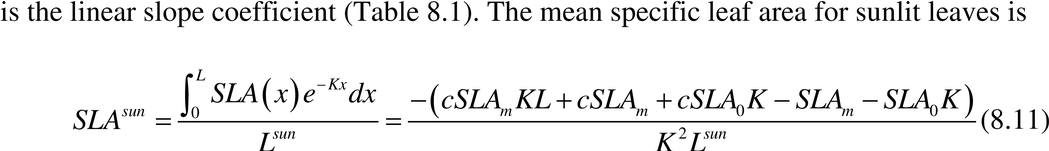

Extracted Item #4
Page: 6
Bounding Box: [ 218.  742. 1265. 1066.]
Score: 0.993889331817627


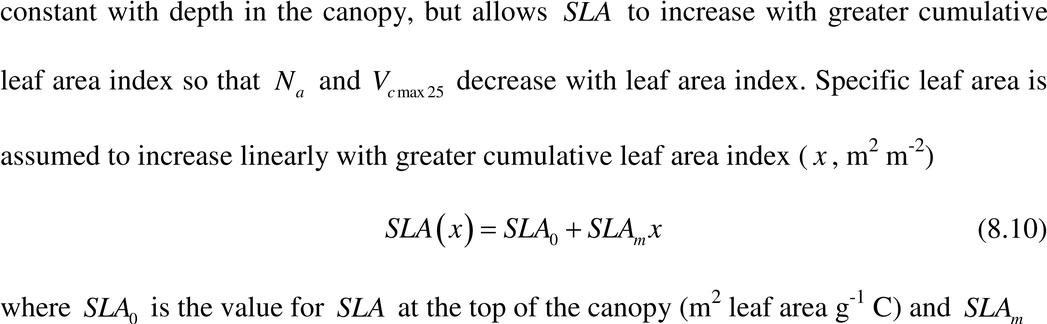

In [55]:
# Tables
show_extractions(
    SAMPLE_PDF_PATH.replace('.pdf','_tables.parquet'), 
    'obj_bbs',
    'obj_page')


# Validate Results

COSMOS provides the /healthcheck/evaluate endpoint to evaluate the output of a COSMOS job against an expected set of region bounding boxes. Expected bounding boxes can be generated
by the [COSMOS tagger tool](https://github.com/uw-cosmos/cosmos-visualizer), but should be converted from XML to JSON for use with the health check endpoint. The health check endpoint
returns the [mean average precision score](https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)#Mean_average_precision) for each of the 3 relevant region
identification classes (figures, tables, and equations) according to the following procedure:

* For each threshold between 50% and 95%, in 5% intervals:
* Label each Cosmos extraction as a true positive if its intersection-over-union with a ground truth region is greater than the threshold
* Compute the [average precision](https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)#Average_precision) of the set of extractions at the given threshold
  * Average Precision is a measure of the change in precision and recall of the model as results with lower confidence scores are considered
* Average the average precision score from each i-o-u threshold

In [73]:
evaluate_endpoint = COSMOS_BASE_URL + f'/healthcheck/evaluate/{job_id}'
with open(SAMPLE_PDF_PATH + '.json', 'rb') as expected_regions:

    response = requests.post(evaluate_endpoint, json=json.loads(expected_regions.read()))

    print(json.dumps(response.json(),indent=2))


[
  {
    "label_class": "Figure",
    "page_comparisons": [
      {
        "page": 2,
        "expected_count": 1,
        "cosmos_count": 1,
        "expected_area": 523569,
        "cosmos_area": 520344,
        "average_precision": 1.0,
        "ap50": 1.0,
        "ap75": 1.0,
        "count_in_bounds": true
      },
      {
        "page": 3,
        "expected_count": 4,
        "cosmos_count": 4,
        "expected_area": 822219,
        "cosmos_area": 805650,
        "average_precision": 1.0,
        "ap50": 1.0,
        "ap75": 1.0,
        "count_in_bounds": true
      },
      {
        "page": 4,
        "expected_count": 4,
        "cosmos_count": 4,
        "expected_area": 858235,
        "cosmos_area": 817035,
        "average_precision": 0.975,
        "ap50": 1.0,
        "ap75": 1.0,
        "count_in_bounds": true
      },
      {
        "page": 5,
        "expected_count": 4,
        "cosmos_count": 4,
        "expected_area": 821191,
        "cosmos_area": 809992